# import modules

In [8]:
from vnpy.app.cta_strategy.backtesting import BacktestingEngine, OptimizationSetting  
from vnpy.app.cta_strategy.base import BacktestingMode   #backtesting 
from datetime import datetime    #time
from vnpy.trader.constant import Interval, Exchange
# from vnpy.app.atr_rsi_strategy import AtrRsiStrategy

from vnpy.app.portfolio_strategy.backtesting import BacktestingEngine as PairBacktestEngine

import matplotlib
%matplotlib inline

backtesting的 package 為 vnpy回測包，本身會調用: 指定路徑的database、特殊data數據類型儲存物件、pandas、datetime等 回測所需的function   

 #BacktestingEngine為回測主引擎，包含交易各項參數設定、加入交易策略、加入特定下單類型、載入回測期間、統計結果、優化參數執行   
 #OptimizationSetting為參數優化的設定Location，設定特定商品、特定數字區間來完成優化
 

base 的package定義了CTA模塊中用到的一些基礎設置，如引擎類型（回測/實盤），回測模式（K線/Tick），本地停止單的定義以及停止單狀態（等待中/已撤銷/已觸發）。

 #BacktestingMode處理回測類型的設定
 #constant的package 本身調用 enum(枚舉)，用來設定特定常數，如交易所類型、持倉資訊、時間間隔
    

# trading cost

In [9]:
import re

def getCommission(symbol,
                  exchange,
                  cost,
                  multiplier,
                  qty,
                  Real=False,
                  direction=''):
    """計算個別部位的單邊交易成本"""
    try:
        if exchange == 'TFE':
            if re.match('MTX[0-9]*', symbol):  # 小台指期
                return 50 + (1 * 50 + cost * (2 / 100000) * multiplier
                             ) * qty if not Real else 50 + (cost *
                                                            (2 / 100000) *
                                                            multiplier) * qty
            elif re.match('TX[0-9]*',
                          symbol) or re.match('TE[0-9]*', symbol) or re.match(
                              'TF[0-9]*', symbol):  # 大台指期
                return 50 + (1 * 200 + cost * (2 / 100000) * multiplier
                             ) * qty if not Real else 50 + (cost *
                                                            (2 / 100000) *
                                                            multiplier) * qty
            elif re.match(r"TX[O0-9][0-9]*[A-Z][0-9]", symbol):  # 台指選
                return 30 + (getMinimumTickOpt(cost) + cost * 2 /
                             100000) * qty * multiplier if not Real else 30 + (
                                 cost * 2 / 100000) * qty * multiplier
            elif re.match(r"[A-Z][A-Z]F[0-9][0-9]", symbol):  # 個股期貨
                return 50 + (
                    getMinimumTick(cost) + cost *
                    (2 / 100000)) * qty * multiplier if not Real else 50 + (
                        cost * (2 / 100000)) * qty * multiplier
        elif exchange == 'TSE':
            tick = getMinimumTick(cost)
            commission = cost * (0.1425 / 100) * multiplier
            commission = 20 if commission < 20 else commission
            fee = cost * (0.3 / 100) * multiplier
            slide = tick * multiplier
            if direction == 'EXIT' or direction == 0:
                return (commission + fee +
                        slide) * qty if not Real else (commission + fee) * qty
            else:
                return (commission +
                        slide) * qty if not Real else commission * qty
    except Exception as e:
        print(e)


計算交易成本，"getCommission" 參數設定，作為 portfolio_strategy.backtesting 中的Class: BacktestingEngine 中的def: set_parameters 裡手續費價格參數: rates=Dict[str, float]

# minimum tick

In [10]:
def getMinimumTickOpt(cost):
    if cost < 10:
        return 0.1
    elif cost < 50:
        return 0.5
    elif cost < 500:
        return 1
    elif cost < 1000:
        return 5
    else:
        return 10


def getMinimumTick(cost):
    if cost < 10:
        return 0.01
    elif cost < 50:
        return 0.05
    elif cost < 100:
        return 0.1
    elif cost < 500:
        return 0.5
    elif cost < 1000:
        return 1
    else:
        return 5

# pair trading strategy (if Zscore > std)

In [12]:
from typing import List, Dict
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

from vnpy.app.portfolio_strategy import StrategyTemplate, StrategyEngine
from vnpy.trader.utility import BarGenerator
from vnpy.trader.object import TickData, BarData


In [13]:
zscore_last_array = pd.DataFrame([(float('NaN'))], columns=['Z Score'])  #create zscore array
cadf_array = pd.DataFrame([(float('NaN'))], columns=['P-Value'])    #create p value array


class PairTradingStrategy(StrategyTemplate):  #inlude this object
    """"""

    author = "Kevin at XQC"

#     price_add = getMinimumTick
    ols_window = 120  #多少跟K棒
    zscore_high = 2  #幾個標準差 (Z表)
    zscore_low = 1
    boll_dev = 2    #價差布林標準差
    fixed_size = 1  
#     leg1_ratio = 1
#     leg2_ratio = 1
    leg1_close = []  
    leg2_close = []  

    leg1_symbol = ""
    leg2_symbol = ""
    # last_spread = 0.0
    current_spread = 0.0
    boll_mid = 0.0
    boll_down = 0.0
    boll_up = 0.0

    parameters = [
        "price_add",  #滑價
        "boll_window",
        "boll_dev",
        "fixed_size",
        "leg1_ratio",
        "leg2_ratio",
    ]
    variables = [
        "leg1_symbol",
        "leg2_symbol",
        "current_spread",
        "boll_mid",
        "boll_down",
        "boll_up",
    ]

    def __init__(self, strategy_engine: StrategyEngine, strategy_name: str,
                 vt_symbols: List[str], setting: dict):
        """"""
        super().__init__(strategy_engine, strategy_name, vt_symbols, setting)

        self.bgs: Dict[str, BarGenerator] = {}
        self.targets: Dict[str, int] = {}
        self.last_tick_time: datetime = None

        # Obtain contract info
        self.leg1_symbol, self.leg2_symbol = vt_symbols

        def on_bar(bar: BarData):
            """"""
            pass

        for vt_symbol in self.vt_symbols:
            self.targets[vt_symbol] = 0
            self.bgs[vt_symbol] = BarGenerator(on_bar)

    def on_init(self):
        """
        Callback when strategy is inited.
        """
        self.write_log("策略初始化")

        self.load_bars(1)

    def on_start(self):
        """
        Callback when strategy is started.
        """
        self.write_log("策略启动")

    def on_stop(self):
        """
        Callback when strategy is stopped.
        """
        self.write_log("策略停止")

    def on_tick(self, tick: TickData):
        """
        Callback of new tick data update.
        """
        if (self.last_tick_time
                and self.last_tick_time.minute != tick.datetime.minute):
            bars = {}
            for vt_symbol, bg in self.bgs.items():
                bars[vt_symbol] = bg.generate()
            self.on_bars(bars)

        bg: BarGenerator = self.bgs[tick.vt_symbol]
        bg.update_tick(tick)

        self.last_tick_time = tick.datetime
        

    def on_bars(self, bars: Dict[str, BarData]):
        """"""
        #         self.cancel_all()
        global zscore_last_array, cadf_array   #modify the variable outside of the current scope.

        # Return if one leg data is missing
        if self.leg1_symbol not in bars or self.leg2_symbol not in bars:
            return

        # Calculate current spread
        leg1_bar = bars[self.leg1_symbol]
        leg2_bar = bars[self.leg2_symbol]

        # Filter time only run every 5 minutes
        #         if (leg1_bar.datetime.minute + 1) % 5:
        #             return
        
        self.leg1_close.append(leg1_bar.close_price)
        self.leg2_close.append(leg2_bar.close_price)
        
        if len(self.leg1_close) >= self.ols_window and len(self.leg2_close) >= self.ols_window:
            
            # calculate hedge ratio
            self.hedge_ratio = sm.OLS(self.leg1_close, self.leg2_close).fit().params[0]  # OLS回歸，Params[0]第幾個參數的係數
            
            # calculate spread
            spread = np.subtract(self.leg1_close, np.multiply(self.hedge_ratio, self.leg2_close))
            
            # calculate zscore
            z_score = ((spread - np.mean(spread))/np.std(spread))
            
            # record z score
            zscore_last_array = zscore_last_array.append(pd.DataFrame([z_score[-1]], columns=['Z Score']), ignore_index=True)
            
            # cointegration test
            cadf = ts.adfuller(z_score)[1]
            # record p-value
            cadf_array = cadf_array.append(pd.DataFrame([cadf], columns=['P-Value']), ignore_index=True)
            
            # set position
            self.calculate_xy_signals(bars, z_score[-1], cadf)
            self.leg1_close.pop(0)
            self.leg2_close.pop(0)
            
    def calculate_xy_signals(self, bars, zscore_last, cadf):

        hr = round(abs(self.hedge_ratio))
        
        # Calculate new target position
        leg1_pos = self.get_pos(self.leg1_symbol)
#       #  if abs(zscore_last) >= 2 or cadf <= 0.05:
#             print(zscore_last, cadf)
        if not leg1_pos:
            if zscore_last >= self.zscore_high and cadf <= 0.05:    #顯著定態，可預測，數據有隨著時間的趨勢變化
                self.targets[self.leg1_symbol] = -1
                self.targets[self.leg2_symbol] = 1 * hr
            elif zscore_last <= -self.zscore_high and cadf <= 0.05:
                self.targets[self.leg1_symbol] = 1
                self.targets[self.leg2_symbol] = -1 * hr
        elif leg1_pos != 0:
            if abs(zscore_last) <= self.zscore_low and cadf <= 0.05 or cadf > 0.05:
                self.targets[self.leg1_symbol] = 0
                self.targets[self.leg2_symbol] = 0
        else:
            if cadf > 0.05:                         #非定態，市場多數時候特性
                self.targets[self.leg1_symbol] = 0
                self.targets[self.leg2_symbol] = 0

        # Execute orders
        for vt_symbol in self.vt_symbols:
            target_pos = self.targets[vt_symbol] #目標多空
            current_pos = self.get_pos(vt_symbol) #現在多空

            pos_diff = target_pos - current_pos   #calculate open and close   1/-1/0= buy/short/ no action
            volume = abs(pos_diff)
            bar = bars[vt_symbol]

            if pos_diff > 0:                            
                price = bar.close_price + self.price_add(bar.close_price)  #滑價計算 

                if current_pos < 0:
                    self.cover(vt_symbol, price, volume)
                else:
                    self.buy(vt_symbol, price, volume)
            elif pos_diff < 0:
                price = bar.close_price - self.price_add(bar.close_price)

                if current_pos > 0:
                    self.sell(vt_symbol, price, volume)
                else:
                    self.short(vt_symbol, price, volume)

        self.put_event()
        
    def price_add(self, cost):
        return getMinimumTick(cost)

In [18]:
a = 3
def A():
#     global a
    a = 5
A()
print(a)

5


# start testing

2020-10-20 13:31:14.083752	开始加载历史数据
2020-10-20 13:31:14.099814	1101.TSE加载进度： [1%]
2020-10-20 13:31:14.109485	1101.TSE加载进度： [2%]
2020-10-20 13:31:14.121624	1101.TSE加载进度： [2%]
2020-10-20 13:31:14.134390	1101.TSE加载进度： [3%]
2020-10-20 13:31:14.146429	1101.TSE加载进度： [4%]
2020-10-20 13:31:14.158433	1101.TSE加载进度： [5%]
2020-10-20 13:31:14.180503	1101.TSE加载进度： [6%]
2020-10-20 13:31:14.188665	1101.TSE加载进度： [7%]
2020-10-20 13:31:14.199496	1101.TSE加载进度： [7%]
2020-10-20 13:31:14.212461	1101.TSE加载进度： [8%]
2020-10-20 13:31:14.224432	1101.TSE加载进度： [9%]
2020-10-20 13:31:14.232437	1101.TSE加载进度： [10%]
2020-10-20 13:31:14.245575	1101.TSE加载进度：# [11%]
2020-10-20 13:31:14.258496	1101.TSE加载进度：# [11%]
2020-10-20 13:31:14.271462	1101.TSE加载进度：# [12%]
2020-10-20 13:31:14.280616	1101.TSE加载进度：# [13%]
2020-10-20 13:31:14.293648	1101.TSE加载进度：# [14%]
2020-10-20 13:31:14.305748	1101.TSE加载进度：# [15%]
2020-10-20 13:31:14.317410	1101.TSE加载进度：# [16%]
2020-10-20 13:31:14.329504	1101.TSE加载进度：# [16%]
2020-10-20 13:31:14.348442	

2020-10-20 13:31:15.993450	1102.TSE加载进度：### [37%]
2020-10-20 13:31:16.006538	1102.TSE加载进度：### [38%]
2020-10-20 13:31:16.015877	1102.TSE加载进度：### [39%]
2020-10-20 13:31:16.025565	1102.TSE加载进度：### [39%]
2020-10-20 13:31:16.034463	1102.TSE加载进度：#### [40%]
2020-10-20 13:31:16.041444	1102.TSE加载进度：#### [41%]
2020-10-20 13:31:16.046430	1102.TSE加载进度：#### [42%]
2020-10-20 13:31:16.053411	1102.TSE加载进度：#### [43%]
2020-10-20 13:31:16.059328	1102.TSE加载进度：#### [44%]
2020-10-20 13:31:16.066276	1102.TSE加载进度：#### [44%]
2020-10-20 13:31:16.073258	1102.TSE加载进度：#### [45%]
2020-10-20 13:31:16.079241	1102.TSE加载进度：#### [46%]
2020-10-20 13:31:16.090272	1102.TSE加载进度：#### [47%]
2020-10-20 13:31:16.106589	1102.TSE加载进度：#### [48%]
2020-10-20 13:31:16.115546	1102.TSE加载进度：#### [48%]
2020-10-20 13:31:16.127459	1102.TSE加载进度：#### [49%]
2020-10-20 13:31:16.143560	1102.TSE加载进度：##### [50%]
2020-10-20 13:31:16.158443	1102.TSE加载进度：##### [51%]
2020-10-20 13:31:16.169531	1102.TSE加载进度：##### [52%]
2020-10-20 13:31:16.180506	1102.

c:\users\j4a3m\anaconda3\envs\vnpy_env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\j4a3m\anaconda3\envs\vnpy_env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\j4a3m\anaconda3\envs\vnpy_env\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
c:\users\j4a3m\anaconda3\envs\vnpy_env\lib\site-packages

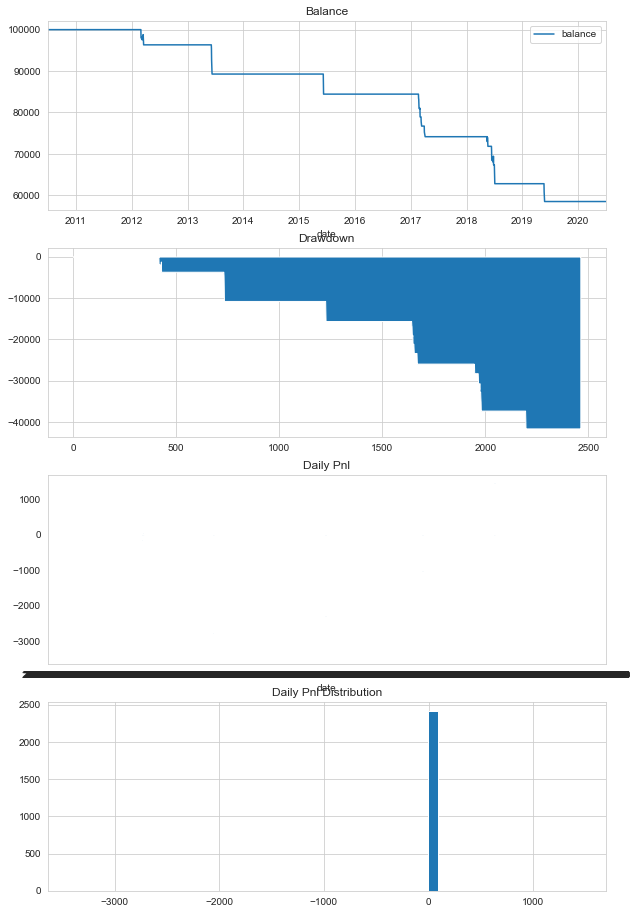

In [16]:
# from vnpy.trader.constant import Interval, Exchange
tickers = '1101.TSE,1102.TSE'.split(',')
pairengine = PairBacktestEngine()
pairengine.set_parameters(
    vt_symbols=tickers,
    interval=Interval.DAILY,
    start=datetime(2010, 6, 30),
    end=datetime(2020, 6, 30),
    rates=dict((ticker, getCommission) for ticker in tickers),
    slippages=dict((ticker, 1) for ticker in tickers),
    sizes=dict((ticker, 1000) for ticker in tickers),
    priceticks=dict((ticker, getMinimumTick) for ticker in tickers),
    capital=100_000,
#     mode=BacktestingMode.BAR,
    collection_name=dict((ticker, 'TSE') for ticker in tickers))
pairengine.add_strategy(PairTradingStrategy, {})
pairengine.load_data()
pairengine.run_backtesting()
df = pairengine.calculate_result()
pairengine.calculate_statistics()
pairengine.show_chart()